# ✳ Neural Network
## ✅ 손글씨 숫자 인식 - Forward Propagation
### 기계학습과 마찬가지로 신경망도 두 단계를 거쳐 문제를 해결
1. 훈련 데이터를 사용해 가중치 매개변수를 학습
2. 추론 단계에서 앞서 학습한 매개변수를 사용하여 입력 데이터를 분류

### ▶ MNIST 데이터셋
- 기계학습에서 주로 사용되는 실험용 이미지 dataset
- 훈련이미지로 모델을 학습하고 ➡ 학습한 모델로 시험이미지를 얼마나 잘 분류하는지 평가

In [8]:
import sys
import os
sys.path.append(os.pardir) # 부모 directory의 파일 가져오기
from dataset.mnist import load_mnist # mnist dataset load function import

# MNIST dataset load
'''
normalize - 입력 img의 픽셀값을 0.0~1.0사이로 정규화 할것인지, 안하면 0~255 원본값 유지
flatten - 입력 이미지를 평탄하게 784개의 원소의 1차원 배열로 만들것인지, 안하면 1*28*28 3차원 배열로 유지
one-hot-label - label을 원-핫 인코딩 형태로 저장할 것인지
'''
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

# print data shape
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [12]:
# show image
import numpy as np
from PIL import Image

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img)) # numpy로 저장된 img를 PIL용 data객체로 변환
    pil_img.show()

img = x_train[0]
label = t_train[0]
print('img label : ', label)

print('before img shape : ', img.shape)
img = img.reshape(28, 28) # 1차원 numpy array로 저장된 img를 다시 28*28 크기로 변형
print('after img shape : ', img.shape)

img_show(img)

img label :  5
before img shape :  (784,)
after img shape :  (28, 28)


### ▶ 신경망의 추론 처리
- input-layer의 neuron : 784 | output-layer의 neuron : 10
    - 이미지 크기가 $28*28 = 784$
    - 0~9까지의 숫자를 구분하므로 10개의 구분
- hidden-layer의 neuron : 50, 100
    - 임의의 값

In [59]:
import pickle
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)
    return x_test, t_test

# pickle file(sample_weight.pkl)에 저장된 '학습된 가중치 매개변수' load
def init_network():
    with open("sample_weight.pkl", 'rb')as f:
        network = pickle.load(f)
        
    return network

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
#     temp_x = x.tolist()
#     for i in range(len(temp_x)):
#         x1 = temp_x[i]
        
#         # 원소 값이 작을 경우 -x하는 과정에서 overflow가 발생할 수 있으므로
#         # if문을 통해 조건을 걸어서 리턴
#         if x1 < 0:
#             temp_x[i] = np.exp(x1) / (1 + np.exp(x1))
#         else:
#             temp_x[i] = 1 / (1 + np.exp(-x1))
    
#     return np.array(temp_x)

def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    
    c = np.max(a) # overflow방지
    a -= c
    
    y =  np.exp(a) / np.sum(np.exp(a))
    
    return y
    
# 각 label의 확률을 numpy array로 return
def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    d1 = sigmoid(a1)
    
    a2 = np.dot(d1, W2) + b2
    d2 = sigmoid(a2)
    a3 = np.dot(d2, W3) + b3
    y = softmax(a3)
    
    return y

In [55]:
# main
x, t = get_data() # get dataset
network = init_network() # create network
accuracy_cnt = 0 # 분류가 얼마나 올바른지 판단
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y) # 확률이 가장 높은 원소의 index 얻기
    
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy: ", str(float(accuracy_cnt) / len(x)))

Accuracy:  0.9207


- 정규화 normalization : 데이터를 특정 범위로 변환하는 처리
    - load_mnist(normalize=True)
- 전처리 pre-processing : 신경망의 input data에 대한 특정 변환을 가하는 것
    - 즉, input image data에 대한 pre-processing으로 normalization을 수행한 것으로 해석

### 💡 NOTE
- 전처리를 통해 식별 능력을 개선
- 위 샘플코드에서는 각 픽셀의 값을 255로 나누는 단순한 정규화를 수행
- 현업에서는 데이터 전체의 분포를 고려하여 전처리 수행
    - ex. 데이터 전체 평균과 표준편차를 이용하여 데이터를 0을 중심으로 분포하도록 이동
    - ex. 데이터의 확산 범위를 제한하기 위해 normalize
    - ex. 전체 데이터를 균일하게 분포시키는 데이터 백색화 whitening

## ✅ Batch
### 💡 NOTE
- batch 처리는 이미지 1장당 처리시간을 대폭 줄여준다
    1. 수치 계산 lib 대부분이 큰 배열을 효율적으로 처리하도록 설계
    2. 커다란 신경망에서는 데이터 전송에서 병목이 발생 할 수 있음
    -> 그래서 배치 처리를 통해 bus에 주는 부하를 감소시킬 수 있음
    -> I/O를 통해 데이터를 읽는 시간을 줄이고, 순수 CPU, GPU 사용률을 높이기
    
####    

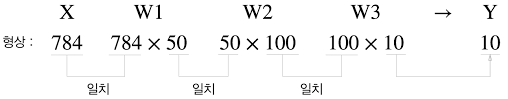

####    

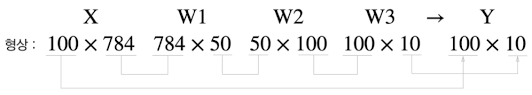

####    

- 위와 같이 이미지 100장의 분량의 input에 대한 출력이 한번에 수행될 수 있음

In [60]:
x, t = get_data()
network = init_network()

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i + batch_size] # batch의 크기만큼 한번에 묶기
    y_batch = predict(network, x_batch) # batch 묶음을 한번에 처리
    
    p = np.argmax(y_batch, axis = 1)
    accuracy_cnt += np.sum(p == t[i:i + batch_size])

print("Accuracy: ", str(float(accuracy_cnt) / len(x)))

Accuracy:  0.9207


C:\Users\hyosun\AppData\Local\Temp\ipykernel_11128\2019075988.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


### ▶ 정리
- 신경망은 각 층의 뉴런들이 다음 층의 뉴런으로 신호를 전달 -> 퍼셉트론과 유사
- 다만, 신경망에서는 매끄럽게 변화하는 sigmoid function/ReLU function을,
- 퍼셉트론에서는 급격히 변화하는 step function을 사용했다는 차이

- numpy의 다차원 배열을 활용하면 효율적 처리 OK
- output-layer에서 activation function으로
    - 회귀에서는 항등함수
    - 분류에서는 softmax
- output-layer의 neuron의 수 == 분류하려는 class의 수
- 추론 처리를 batch 단위로 진행하면 훨씬 효율적